In [1]:
pip install datasets

In [2]:
from datasets import get_dataset_config_names

In [3]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for xtreme contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xtreme
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


XTREME has 183 configurations


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
from datasets import load_dataset

In [6]:
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
#return a datasetdict if a key doesnt exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    #load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
        )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for xtreme contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xtreme
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [8]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index = ["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}:{value}")

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [11]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [12]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [13]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
from collections import Counter

In [15]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [16]:
from transformers import AutoTokenizer

In [17]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [18]:
text = "Jack Sparow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##row', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spa', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [19]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparow loves New York!</s>'

In [20]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [21]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self,config):
        super().__init__(config)
        self.num_labels = config.num_labels
        #load model body
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        #set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        #load and initialize weights
        self.init_weights()

    def forward(self, input_ids = None, attention_mask = None, token_type_ids=None, labels=None, **kwargs):
        #use model body to get encoder representation
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        #apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        #Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels),labels.view(-1))
        #return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions = outputs.attentions)




In [22]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [23]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes,id2label = index2tag, label2id=tag2index)

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spa,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,10959,15555,5161,7,2356,5753,38,2


In [26]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
shape of outputs: torch.Size([1, 10, 7])


In [27]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spa,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,I-LOC,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,B-LOC,B-PER,B-PER


In [28]:
def tag_text(text, tags, model, tokenizer):
    #get tokens with special charactes
    tokens = tokenizer(text).tokens()
    #encode the sequence into Ids
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    #get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    #take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    #convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens,preds], index = ["tokens", "tags"])

In [29]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [30]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens= xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [31]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [32]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [33]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"],max_length=128,  # Added truncation
                                      padding='max_length', truncation=True, is_split_into_words=True)

    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [34]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=["langs", "ner_tags", "tokens"])

In [35]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [36]:
pip install seqeval

In [37]:
from seqeval.metrics import classification_report


In [38]:
y_true = [["O", "O", "O", "B-Misc", "I-Misc", "I-Misc", "O"], ["B-Per", "I-Per", "O"]]
y_pred = [["O", "O", "B-Misc", "I-Misc", "I-Misc", "I-Misc", "O"], ["B-Per", "I-Per", "O"]]

In [39]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        Misc       0.00      0.00      0.00         1
         Per       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [40]:
import numpy as np

In [41]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            #ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list

In [42]:
from transformers import TrainingArguments

In [43]:
pip install accelerate -U

In [44]:
pip install 'transformers[torch]'


In [45]:
num_epochs = 3
batch_size = 4
gradient_accumulation_steps = 4
total_steps_per_epoch = len(panx_de_encoded["train"]) // batch_size
logging_steps = max(1, total_steps_per_epoch // 10)  # Log 10 times per epoch, for example

model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    fp16=False,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,  # Updated value
    push_to_hub=False
)


In [46]:
from seqeval.metrics import f1_score


In [47]:

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [48]:
from transformers import DataCollatorForTokenClassification

In [49]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [50]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [51]:
from transformers import Trainer

In [52]:
trainer = Trainer(model_init=model_init, args=training_args, data_collator = data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],eval_dataset=panx_de_encoded["validation"],tokenizer=xlmr_tokenizer)

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
0,0.223300,0.177767,0.820827
1,0.131200,0.151869,0.846607
2,0.084200,0.148019,0.864209


TrainOutput(global_step=2358, training_loss=0.16300676635405692, metrics={'train_runtime': 1271.142, 'train_samples_per_second': 29.69, 'train_steps_per_second': 1.855, 'total_flos': 2464662418808832.0, 'train_loss': 0.16300676635405692, 'epoch': 3.0})

In [54]:
from torch.nn.functional import cross_entropy

In [55]:
def forward_pass_with_label(batch):
  #convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  #pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    #pass data through model
    output = trainer.model(input_ids, attention_mask)
    #logits.size: [batch.size, sequence_length, classes]
    #predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis = -1).cpu().numpy()
  #calculate loss per token after flattening batch dimensions with view
  loss = cross_entropy(output.logits.view(-1,7),labels.view(-1), reduction="none")
  #unflatten batch dimensions and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss":loss, "predicted_label": predicted_label}

In [56]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [57]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN, IG...","[0.0, 0.0059424154, 0.0, 0.0058099204, 0.00488...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>, <pa..."


In [58]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.00,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.08,B-ORG,▁Luz
1,10,1,I-ORG,0.05,I-ORG,▁a


In [59]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) #get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁/,▁von,▁und,▁(,▁),▁'',▁D
count,6066,1388,989,163,808,1171,246,246,2898,89
mean,0.03,0.11,0.15,0.71,0.13,0.09,0.35,0.33,0.02,0.65
sum,207.15,147.97,147.09,115.85,104.03,101.56,85.37,79.96,71.07,58.17


In [60]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.65,0.63,0.53,0.3,0.29,0.21,0.03
sum,1739.15,926.69,2030.44,939.49,826.39,871.22,1351.77


In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [62]:
import matplotlib.pyplot as plt


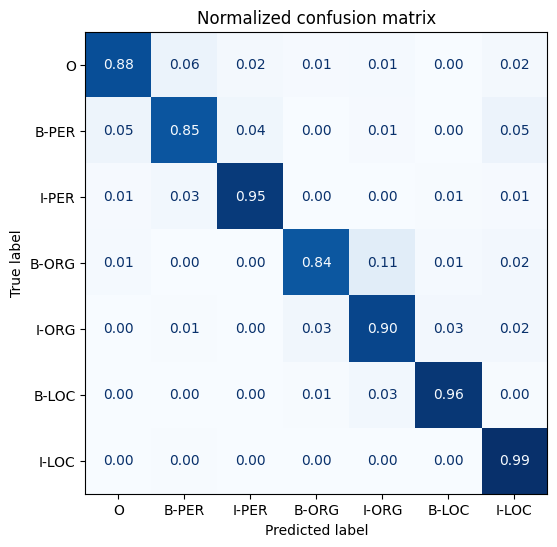

In [63]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [64]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]: .2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
    yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,...,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
losses,8.83,0.00,0.00,7.00,9.44,9.03,7.41,0.00,8.99,8.91,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,...,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,...,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.86,0.00,0.01,0.00,10.77,9.49,7.44,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,...,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,...,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.85,6.00,6.02,0.00,6.13,0.00,5.64,0.00,5.47,5.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [65]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN,IGN,IGN,IGN,IGN,...,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
losses,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN,IGN,IGN,...,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,...,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [66]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [67]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']: .3f}")

F1-score of [de] model on [de] dataset:  0.869


In [68]:
text_fr = "Jedd Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,<s>,▁Jed,d,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
tags,O,B-PER,I-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [69]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1 score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1 score of [de] model on [fr] dataset: 0.700


In [70]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']: .3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset:  0.663


In [71]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-scores of [de] model on [en] dataset: {f1_scores['de']['en']: .3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-scores of [de] model on [en] dataset:  0.587


In [72]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    # Update the logging_steps to ensure logging occurs at least once per epoch
    logging_steps = max(1, len(train_ds) // batch_size)

    # Create new TrainingArguments inside the function to update logging_steps
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_steps=logging_steps,  # Use the updated logging_steps
        log_level='info',  # Set log_level to 'info' to enable logging of training loss
        evaluation_strategy="epoch",
        save_steps=1e6,
        weight_decay=0.01,
        push_to_hub=False,
        # ... add other necessary arguments ...
    )

    # Initialize Trainer with the updated training_args
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer
    )
    trainer.train()

    # Evaluate the model to get the F1 score
    result = trainer.evaluate(test_ds)
    f1_score_value = result['eval_f1']

    # Return a DataFrame with the number of samples and the F1 score
    return pd.DataFrame({"num_samples": [num_samples], "f1_score": [f1_score_value]})


In [73]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [74]:
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobe

{'loss': 1.3301, 'learning_rate': 3.35978835978836e-05, 'epoch': 0.98}
{'eval_loss': 0.8977905511856079, 'eval_f1': 0.38783633179430027, 'eval_runtime': 17.2753, 'eval_samples_per_second': 132.559, 'eval_steps_per_second': 33.169, 'epoch': 1.0}
{'loss': 0.6683, 'learning_rate': 1.7195767195767195e-05, 'epoch': 1.97}


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


{'eval_loss': 0.6132202744483948, 'eval_f1': 0.6119213696892835, 'eval_runtime': 19.2556, 'eval_samples_per_second': 118.927, 'eval_steps_per_second': 29.758, 'epoch': 2.0}
{'loss': 0.3798, 'learning_rate': 7.936507936507937e-07, 'epoch': 2.95}


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


{'eval_loss': 0.5580971240997314, 'eval_f1': 0.6780551905387648, 'eval_runtime': 26.9568, 'eval_samples_per_second': 84.951, 'eval_steps_per_second': 21.256, 'epoch': 3.0}
{'train_runtime': 101.8827, 'train_samples_per_second': 7.361, 'train_steps_per_second': 1.855, 'train_loss': 0.7842935881917439, 'epoch': 3.0}
{'eval_loss': 0.5400149822235107, 'eval_f1': 0.6792688642399625, 'eval_runtime': 19.8197, 'eval_samples_per_second': 115.542, 'eval_steps_per_second': 28.911, 'epoch': 3.0}


,num_samples,f1_score
0,250,0.679269


In [75]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(
      train_on_subset(panx_fr_encoded, num_samples), ignore_index=True
  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

Epoch,Training Loss,Validation Loss,F1
1,1.045600,0.523834,0.601255
2,0.449200,0.521922,0.684202
3,0.275000,0.576822,0.735265


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


<ipython-input-75-7856406e2d3d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if yo

Epoch,Training Loss,Validation Loss,F1
1,0.826800,0.496889,0.717232
2,0.391700,0.520321,0.746780
3,0.244800,0.489374,0.788302


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


<ipython-input-75-7856406e2d3d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if yo

Epoch,Training Loss,Validation Loss,F1
1,0.679200,0.583969,0.738815
2,0.374300,0.494809,0.781601
3,0.234500,0.464183,0.813474


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


<ipython-input-75-7856406e2d3d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if yo

Epoch,Training Loss,Validation Loss,F1
1,0.578100,0.398023,0.775834
2,0.333600,0.419824,0.812205
3,0.209100,0.421782,0.838317


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4
***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


<ipython-input-75-7856406e2d3d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


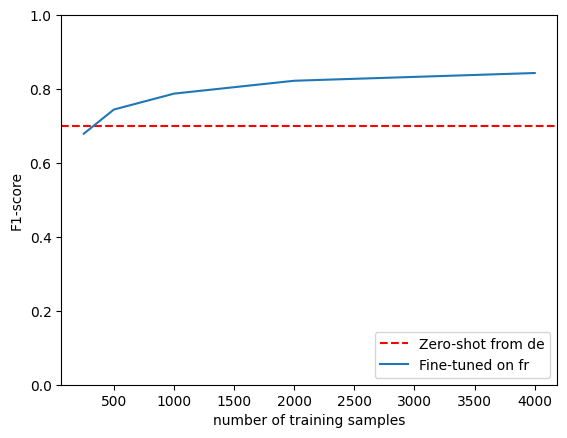

In [76]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("number of training samples")
plt.ylabel("F1-score")
plt.show()

In [77]:
from datasets import concatenate_datasets

In [78]:
def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]
    ).shuffle(seed=42)
  return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [79]:


# Update the logging_steps directly in the training_args object
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
# Make sure that we log at least once per epoch if the dataset is smaller
training_args.logging_steps = max(1, training_args.logging_steps)

# Update the output_dir in the training_args
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

# Instantiate the Trainer with the existing model_init function and training_args
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"]
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,F1
0,No log,0.235685,0.805682
2,No log,0.180121,0.859160


TrainOutput(global_step=3216, training_loss=0.18919452268685868, metrics={'train_runtime': 1731.2801, 'train_samples_per_second': 29.735, 'train_steps_per_second': 1.858, 'total_flos': 3361503815663616.0, 'train_loss': 0.18919452268685868, 'epoch': 3.0})

In [80]:
for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1: .3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset:  0.868


F1-score of [de-fr] model on [fr] dataset:  0.852


F1-score of [de-fr] model on [it] dataset:  0.794


F1-score of [de-fr] model on [en] dataset:  0.672


In [81]:
corpora = [panx_de_encoded]

In [83]:
#exclude german from iteration
for lang in langs[1:]:
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  #fine tune on monolingual corpus
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  #collect f1-scores in common dict
  f1_scores[lang][lang] = metrics["f1_score"][0]
  #add monolingual corpus to list of corpora to concatenate
  corpora.append(ds_encoded)


loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobe

{'loss': 0.5495, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'eval_loss': 0.45937877893447876, 'eval_f1': 0.762141554782032, 'eval_runtime': 16.9801, 'eval_samples_per_second': 134.864, 'eval_steps_per_second': 33.745, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


{'loss': 0.3233, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'eval_loss': 0.3972647786140442, 'eval_f1': 0.8349807337912548, 'eval_runtime': 16.8155, 'eval_samples_per_second': 136.184, 'eval_steps_per_second': 34.076, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


{'loss': 0.2051, 'learning_rate': 0.0, 'epoch': 3.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2290
  Batch size = 4


{'eval_loss': 0.41093116998672485, 'eval_f1': 0.8504309616359642, 'eval_runtime': 16.7707, 'eval_samples_per_second': 136.548, 'eval_steps_per_second': 34.167, 'epoch': 3.0}
{'train_runtime': 705.5466, 'train_samples_per_second': 19.474, 'train_steps_per_second': 4.869, 'train_loss': 0.35928539736996223, 'epoch': 3.0}


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors


{'eval_loss': 0.423072874546051, 'eval_f1': 0.8513862024500323, 'eval_runtime': 16.9269, 'eval_samples_per_second': 135.288, 'eval_steps_per_second': 33.851, 'epoch': 3.0}


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should prob

Epoch,Training Loss,Validation Loss,F1
1,0.590200,0.335370,0.769857
2,0.279900,0.319166,0.824938
3,0.163500,0.329327,0.859401


***** Running Evaluation *****
  Num examples = 840
  Batch size = 4
***** Running Evaluation *****
  Num examples = 840
  Batch size = 4
***** Running Evaluation *****
  Num examples = 840
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 840
  Batch size = 4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

Epoch,Training Loss,Validation Loss,F1
1,0.866200,0.537663,0.570825
2,0.466900,0.491139,0.671591
3,0.294300,0.511590,0.708075


***** Running Evaluation *****
  Num examples = 590
  Batch size = 4
***** Running Evaluation *****
  Num examples = 590
  Batch size = 4
***** Running Evaluation *****
  Num examples = 590
  Batch size = 4


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 590
  Batch size = 4


In [84]:
corpora_encoded = concatenate_splits(corpora)

In [86]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

In [87]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

In [88]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
0,No log,0.216357,0.798284
1,No log,0.181210,0.835196
2,No log,0.188495,0.857308


TrainOutput(global_step=3753, training_loss=0.20174591121373733, metrics={'train_runtime': 2021.3607, 'train_samples_per_second': 29.713, 'train_steps_per_second': 1.857, 'total_flos': 3922799695331328.0, 'train_loss': 0.20174591121373733, 'epoch': 3.0})

In [89]:
for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {"de": f1_scores["de"],
               "each": {lang:f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", inplace=True)

f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8691,0.6999,0.6632,0.5866
each,0.8691,0.8514,0.8261,0.7031
all,0.8655,0.8705,0.8682,0.7735
